<h1><center> 
    Neural network design and application
</center></h1>

<h2><center>CPT_S 434/534, 2022 Spring</center></h2>

<h2><center>HW 6: GANs (100 pts)</center></h2>

### Name: *Xinyu Liu*

## This assignment includes:

## Coding in Python (PyTorch) and answering questions: train GANs (100 points) by using the tutorial code from [Dive into Deep Learning](https://d2l.ai/index.html), section [17.2](https://d2l.ai/chapter_generative-adversarial-networks/dcgan.html). 

Step 0: Read and run the code at section [17.2](https://d2l.ai/chapter_generative-adversarial-networks/dcgan.html) on [Colab](https://colab.research.google.com).

Step 1: Finish the exercise 1 in Section 17.2.6 at [17.2](https://d2l.ai/chapter_generative-adversarial-networks/dcgan.html).

Step 2: Discuss the questions.

## Submission:

* Convert this .ipynb file to .html file, and meanwhile save the tutorial .ipynb file at [17.2](https://d2l.ai/chapter_generative-adversarial-networks/dcgan.html) to .html file (**save the execution outputs** to show your progress: otherwise grading may be affected)
    
* Upload **both** your .ipynb and .html files to Canvas (**NOT a .ZIP file**). Note that you need to submit two .ipynb files and two .html files (**4 files in total**) for this HW

* Deadline: May 1, 11:59 PM, Pacific time (**No extension will be allowed for this HW, but late policy will still apply**).

<!-- * Plots should be clear and easy to read. -->


## Reference

* [Dive into Deep Learning](https://d2l.ai/index.html), section [17.2](https://d2l.ai/chapter_generative-adversarial-networks/dcgan.html).

# 1. (80 pts) Train a GAN on the provided dataset [pokemondb](https://pokemondb.net/sprites)

1) Please use the provided code in [Dive into Deep Learning](https://d2l.ai/index.html), section [17.2](https://d2l.ai/chapter_generative-adversarial-networks/dcgan.html) deep convolutional generative adversarial networks .

2) Choose a library (MXNET, *PYTORCH* or TENSORFLOW, *PYTORCH* prefered) on that page

3) Click "COLAB\[MXNET\]", "COLAB\[PYTORCH\]" or "COLAB\[TENSORFLOW\]" (see [this section](https://d2l.ai/chapter_installation/index.html) for the installation of the used libraries MXNET, PYTORCH for TENSORFLOW if you need to install them). Or directly access these jupyter notebooks at [MXNET](https://colab.research.google.com/github/d2l-ai/d2l-en-colab/blob/master/chapter_generative-adversarial-networks/dcgan.ipynb), [PYTORCH](https://colab.research.google.com/github/d2l-ai/d2l-pytorch-colab/blob/master/chapter_generative-adversarial-networks/dcgan.ipynb) or [TENSORFLOW](https://colab.research.google.com/github/d2l-ai/d2l-tensorflow-colab/blob/master/chapter_generative-adversarial-networks/dcgan.ipynb).

4) (30 pts) Run all code for training a GAN on the pokemon dataset with Colab and save the  execution outputs (if you have any issues running the provided code, please refer to the item 7. below to see any help)

5) (50 pts) Complete exercises 1 in [Section 17.2.6](https://d2l.ai/chapter_generative-adversarial-networks/dcgan.html#exercises): what if use standard ReLU activation rather than leaky ReLU.
You may add your code at the end of the ipynb file on Colab.

Hint for pytorch: 
In the original code, discriminator uses Leaky ReLU as the activation function, so you may follow the discriminator's code to replace the original leaky ReLU with ReLU in discriminator.
You may also find the document of [torch.nn.LeakyReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html#torch.nn.LeakyReLU) and [torch.nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) to see the full description of the interfaces.

6) Download this GAN ipynb file and convert it to html format.

7) If you have an error when running the tutorial code, such as "ImportError: cannot import name '_check_savefig_extra_args' from 'matplotlib.backend_bases'" on Colab, then you may need to add some code to change the versions of libraries. Particularly for the above example error, an easy fix is to add the following code immediately after "!pip install d2l==0.17.5" (the original first line of code):

"!pip install matplotlib==3.1.1"

## TensorFlow import

In [1]:
!pip3 install d2l==0.17.5
import tensorflow as tf
from d2l import tensorflow as d2l

## Dataset

Found 40597 files belonging to 721 classes.


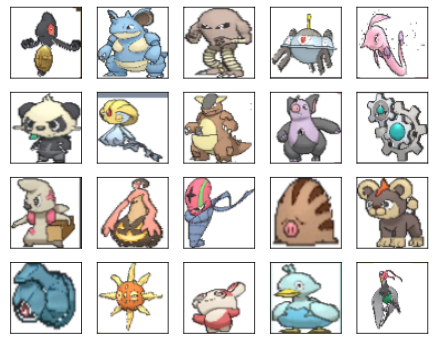

In [2]:

d2l.DATA_HUB['pokemon'] = (d2l.DATA_URL + 'pokemon.zip',
                           'c065c0e2593b8b161a2d7873e42418bf6a21106c')

data_dir = d2l.download_extract('pokemon')
batch_size = 256
pokemon = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, batch_size=batch_size, image_size=(64, 64))


def transform_func(X):
    X = X / 255.
    X = (X - 0.5) / (0.5)
    return X

# For TF>=2.4 use `num_parallel_calls = tf.data.AUTOTUNE`
data_iter = pokemon.map(lambda x, y: (transform_func(x), y),
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)
data_iter = data_iter.cache().shuffle(buffer_size=1000).prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE)


d2l.set_figsize(figsize=(4, 4))
for X, y in data_iter.take(1):
    imgs = X[:20, :, :, :] / 2 + 0.5
    d2l.show_images(imgs, num_rows=4, num_cols=5)

## Define Generator


In [3]:
class G_block(tf.keras.layers.Layer):
    def __init__(self, out_channels, kernel_size=4, strides=2, padding="same",
                 **kwargs):
        super().__init__(**kwargs)
        self.conv2d_trans = tf.keras.layers.Conv2DTranspose(
            out_channels, kernel_size, strides, padding, use_bias=False)
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.activation = tf.keras.layers.ReLU()

    def call(self, X):
        return self.activation(self.batch_norm(self.conv2d_trans(X)))

n_G = 64
net_G = tf.keras.Sequential([
    # Output: (4, 4, 64 * 8)
    G_block(out_channels=n_G*8, strides=1, padding="valid"),
    G_block(out_channels=n_G*4), # Output: (8, 8, 64 * 4)
    G_block(out_channels=n_G*2), # Output: (16, 16, 64 * 2)
    G_block(out_channels=n_G), # Output: (32, 32, 64)
    # Output: (64, 64, 3)
    tf.keras.layers.Conv2DTranspose(
        3, kernel_size=4, strides=2, padding="same", use_bias=False,
        activation="tanh")
])

x = tf.zeros((1, 1, 1, 100))
net_G(x).shape

TensorShape([1, 64, 64, 3])

## Discriminator

In [4]:
class D_block(tf.keras.layers.Layer):
    def __init__(self, out_channels, kernel_size=4, strides=2, padding="same",
                 alpha=0.2, **kwargs):
        super().__init__(**kwargs)
        self.conv2d = tf.keras.layers.Conv2D(out_channels, kernel_size,
                                             strides, padding, use_bias=False)
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.activation = tf.keras.layers.LeakyReLU(alpha)

    def call(self, X):
        return self.activation(self.batch_norm(self.conv2d(X)))

n_D = 64
net_D = tf.keras.Sequential([
    D_block(n_D), # Output: (32, 32, 64)
    D_block(out_channels=n_D*2), # Output: (16, 16, 64 * 2)
    D_block(out_channels=n_D*4), # Output: (8, 8, 64 * 4)
    D_block(out_channels=n_D*8), # Outupt: (4, 4, 64 * 64)
    # Output: (1, 1, 1)
    tf.keras.layers.Conv2D(1, kernel_size=4, use_bias=False)
])

x = tf.zeros((1, 64, 64, 3))
net_D(x).shape

TensorShape([1, 1, 1, 1])

## Training

loss_D 0.249, loss_G 3.263, 293.5 examples/sec on <tensorflow.python.eager.context._EagerDeviceContext object at 0x7fdee7db60f0>


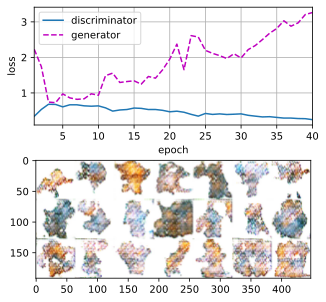

In [ ]:
def train(net_D, net_G, data_iter, num_epochs, lr, latent_dim,
          device=d2l.try_gpu()):
    loss = tf.keras.losses.BinaryCrossentropy(
        from_logits=True, reduction=tf.keras.losses.Reduction.SUM)

    for w in net_D.trainable_variables:
        w.assign(tf.random.normal(mean=0, stddev=0.02, shape=w.shape))
    for w in net_G.trainable_variables:
        w.assign(tf.random.normal(mean=0, stddev=0.02, shape=w.shape))

    optimizer_hp = {"lr": lr, "beta_1": 0.5, "beta_2": 0.999}
    optimizer_D = tf.keras.optimizers.Adam(**optimizer_hp)
    optimizer_G = tf.keras.optimizers.Adam(**optimizer_hp)

    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)

    for epoch in range(1, num_epochs + 1):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3) # loss_D, loss_G, num_examples
        for X, _ in data_iter:
            batch_size = X.shape[0]
            Z = tf.random.normal(mean=0, stddev=1,
                                 shape=(batch_size, 1, 1, latent_dim))
            metric.add(d2l.update_D(X, Z, net_D, net_G, loss, optimizer_D),
                       d2l.update_G(Z, net_D, net_G, loss, optimizer_G),
                       batch_size)

        # Show generated examples
        Z = tf.random.normal(mean=0, stddev=1, shape=(21, 1, 1, latent_dim))
        # Normalize the synthetic data to N(0, 1)
        fake_x = net_G(Z) / 2 + 0.5
        imgs = tf.concat([tf.concat([fake_x[i * 7 + j] for j in range(7)],
                                    axis=1)
                          for i in range(len(fake_x) // 7)], axis=0)
        animator.axes[1].cla()
        animator.axes[1].imshow(imgs)
        # Show the losses
        loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]
        animator.add(epoch, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec on {str(device)}')

latent_dim, lr, num_epochs = 100, 0.0005, 40
train(net_D, net_G, data_iter, num_epochs, lr, latent_dim)

## ReLU instead of LeakyReLU

loss_D 0.626, loss_G 0.874, 299.2 examples/sec on <tensorflow.python.eager.context._EagerDeviceContext object at 0x7f01eb163780>


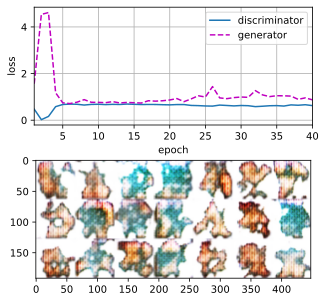

In [5]:
# redefine D_block with ReLU
class D_block(tf.keras.layers.Layer):
    def __init__(self, out_channels, kernel_size=4, strides=2, padding="same",
                 alpha=0.2, **kwargs):
        super().__init__(**kwargs)
        self.conv2d = tf.keras.layers.Conv2D(out_channels, kernel_size,
                                             strides, padding, use_bias=False)
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.activation = tf.keras.layers.ReLU()

    def call(self, X):
        return self.activation(self.batch_norm(self.conv2d(X)))

n_D = 64
net_D = tf.keras.Sequential([
    D_block(n_D), # Output: (32, 32, 64)
    D_block(out_channels=n_D*2), # Output: (16, 16, 64 * 2)
    D_block(out_channels=n_D*4), # Output: (8, 8, 64 * 4)
    D_block(out_channels=n_D*8), # Outupt: (4, 4, 64 * 64)
    # Output: (1, 1, 1)
    tf.keras.layers.Conv2D(1, kernel_size=4, use_bias=False)
])

x = tf.zeros((1, 64, 64, 3))
net_D(x).shape

## Unchanged, copy because colab disconnect
def train(net_D, net_G, data_iter, num_epochs, lr, latent_dim,
          device=d2l.try_gpu()):
    loss = tf.keras.losses.BinaryCrossentropy(
        from_logits=True, reduction=tf.keras.losses.Reduction.SUM)

    for w in net_D.trainable_variables:
        w.assign(tf.random.normal(mean=0, stddev=0.02, shape=w.shape))
    for w in net_G.trainable_variables:
        w.assign(tf.random.normal(mean=0, stddev=0.02, shape=w.shape))

    optimizer_hp = {"lr": lr, "beta_1": 0.5, "beta_2": 0.999}
    optimizer_D = tf.keras.optimizers.Adam(**optimizer_hp)
    optimizer_G = tf.keras.optimizers.Adam(**optimizer_hp)

    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)

    for epoch in range(1, num_epochs + 1):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3) # loss_D, loss_G, num_examples
        for X, _ in data_iter:
            batch_size = X.shape[0]
            Z = tf.random.normal(mean=0, stddev=1,
                                 shape=(batch_size, 1, 1, latent_dim))
            metric.add(d2l.update_D(X, Z, net_D, net_G, loss, optimizer_D),
                       d2l.update_G(Z, net_D, net_G, loss, optimizer_G),
                       batch_size)

        # Show generated examples
        Z = tf.random.normal(mean=0, stddev=1, shape=(21, 1, 1, latent_dim))
        # Normalize the synthetic data to N(0, 1)
        fake_x = net_G(Z) / 2 + 0.5
        imgs = tf.concat([tf.concat([fake_x[i * 7 + j] for j in range(7)],
                                    axis=1)
                          for i in range(len(fake_x) // 7)], axis=0)
        animator.axes[1].cla()
        animator.axes[1].imshow(imgs)
        # Show the losses
        loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]
        animator.add(epoch, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec on {str(device)}')

latent_dim, lr, num_epochs = 100, 0.0005, 40
train(net_D, net_G, data_iter, num_epochs, lr, latent_dim)

# 2. Discussion (20 pts)

## Q. (20 pts) Is there any difference between the generator performance of the GAN model using ReLU and the GAN model using LeakyReLU? What might be the reason?

**Your answer:** Performance of generator is affected by ReLU because input < 0 has no effect, whereas for leakyReLU, it allows some input leak through. Thus, discriminator is more powerful on generator with leakyReLU.



In [ ]:
# convert this file "HW6_GAN_to_Canvas.ipynb" to "HW6_GAN_to_Canvas.html"
!jupyter nbconvert --to html HW6_GAN_to_Canvas.ipynb 


[NbConvertApp] Converting notebook HW6_GAN_to_Canvas.ipynb to html
[NbConvertApp] Writing 581675 bytes to HW6_GAN_to_Canvas.html


In [ ]:
# convert this file "dcgan-2.ipynb" to "dcgan-2.html"
!jupyter nbconvert --to html dcgan-2.ipynb 